<a href="https://colab.research.google.com/github/liuzyon/ACSE-8-colab/blob/main/practical_4/afternoon_lecture_1/Afternoon_Session_4_part1_FromConvolutions_To_ConvNets_Practical_Solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Notebook modified from the original version by `Lukas Mosser` and `Navjot Kukreja`

In [12]:
!pip install pycm livelossplot
%pylab inline

     |████████████████████████████████| 71kB 4.9MB/s 
     |████████████████████████████████| 573kB 36.8MB/s 
Populating the interactive namespace from numpy and matplotlib


## ACSE 8 Session 4:
# From Convolutions to ConvNets

### Objectives of the session

Thursday 6 May 13:00-16:00h:
- Quick overview of convolutions in traditional Computer Vision with examples of... cats.
- Torch layer operations: simple examples with... cats.
- Understanding CNNs.
- Implementation of a network similar to LeNet5.
- Train our LeNet5-like network on MNIST

Friday 7 May 13:00h-16:00h:
- Train MNIST again using data augmentation
- Transfer Learning: bees & ants (***Debbie***)


On practical 2, we learned how to **train a feed-forward network**.
On practical 3, we learned how to **optimise for hyperparameters** with cross-validation.(在实践2中，我们学习了如何训练前馈网络。在实践3中，我们学习了如何通过交叉验证优化超参数)

Today we will use these two techniques on **CNNs**.

<img src="https://miro.medium.com/max/2340/1*Fw-ehcNBR9byHtho-Rxbtw.gif" alt="network" width="600"/>


#### A few imports before we get started

In [24]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit

from livelossplot import PlotLosses
from pycm import *

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import MNIST

# import numpy as np
# import matplotlib.pyplot as plt


def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = False

    return True

device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

Cuda installed! Running on GPU!


### Mounting the google drive for later storage

In [19]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


# Important concepts from previous sessions revisited:

- **Recap 1** `StratifiedShuffleSplit` to split our training dataset into training and validation for k-fold validation:

  - compute indices using `StratifiedShuffleSplit`(计算索引)
  - standardise data（标准化数据）
  - create normalised training, validation, and test datasets as TensorDatasets（创建规范化训练集，验证集，测试集）

In [26]:
# mnist_train和mnist_test自己加的
mnist_train = MNIST("./", download=True, train=True)
mnist_test = MNIST("./", download=True, train=False)

shuffler = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42).split(mnist_train.train_data, mnist_train.train_labels)
indices = [(train_idx, validation_idx) for train_idx, validation_idx in shuffler][0]

def apply_standardization(X):
  X /= 255.
  X -= 0.1307
  X /= 0.3081
  return X

X_train, y_train = apply_standardization(mnist_train.train_data[indices[0]].float()), mnist_train.train_labels[indices[0]]
X_val, y_val = apply_standardization(mnist_train.train_data[indices[1]].float()), mnist_train.train_labels[indices[1]]
X_test, y_test =  apply_standardization(mnist_test.test_data.float()), mnist_test.test_labels

mnist_train = TensorDataset(X_train, y_train.long())
mnist_validate = TensorDataset(X_val, y_val.long())
mnist_test = TensorDataset(X_test, y_test.long())

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:64: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:54: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.7/dist-packages/torchvision

<img src="https://scikit-learn.org/stable/_images/grid_search_cross_validation.png" alt="network" width="500"/>

<br>

- **Recap 2** livelossplot to visualise training evolution

<img src="https://raw.githubusercontent.com/stared/livelossplot/master/livelossplot.gif" alt="network" width="800"/>

## Computer Vision - Convolutions as Feature Detectors（计算机视觉-卷积作为特征检测器）

In the following exercise we'll do some classical computer vision before moving to convolutional networks.
We will use the [Sobel-filter](https://en.wikipedia.org/wiki/Sobel_operator), a classical convolution operator.（在接下来的练习中，我们将在学习卷积网络之前先学习一些经典的计算机视觉。我们将使用Sobel-filter，一个经典的卷积算子）

### Task 1:
Implement the Sobel Filter $G_x$ (according to its wiki definition, see link above) as a simple 2D convolution operation.

- First instantiate a [`nn.Conv2d`](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) object with a single 3x3 kernel, padding=1, taking in a single image channel and outputting one channel.  
- Then modify the weight matrix to reflect the sobel filter.

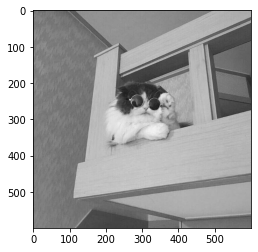

In [28]:
from PIL import Image  # PIL is hte Python Imaging Library
import requests        # library that provides an easy way to make http requests
from io import BytesIO # let's us read raw bites as a file

url = "https://cataas.com/cat" # cat as a service!
response = requests.get(url)   # requests a cat
img = np.array(Image.open(BytesIO(response.content)).convert('L')).astype(float) # BytesIO tells python to read it as a file (and .content extracts only the image bytes)
# print(img)
plt.imshow(img, cmap="gray")   # matplotlib likes numpy arrays

### `code along` Implement the Sobel Filter $G_x$

torch.Size([1, 1, 3, 3])
tensor([[[[ 1.,  0., -1.],
          [ 2.,  0., -2.],
          [ 1.,  0., -1.]]]])


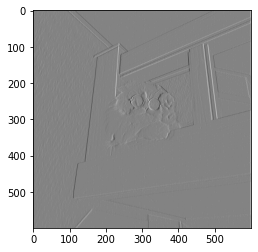

In [29]:
sobel = nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1, bias=False) # define sobel as an instance of an nn.Conv2d class. 定义sobel为一个nn.Conv2d实例
print(sobel.weight.data.size()) # print the size of the filter
filter = torch.Tensor([[1, 0, -1], [2, 0, -2], [1, 0, -1]]).float().view(1, 1, 3, 3) # define a filter as a torch.Tensor with the right coefficients
print(filter) 
sobel.weight.data = filter  # assign filter values to the sobel object
x = torch.from_numpy(img).view(1, 1, img.shape[0], img.shape[1]).float()   # load the cat image as a tensor
filtered_cat = sobel(x)    # filter the cat image 对猫图像进行过滤
plt.imshow(filtered_cat.detach().numpy()[0, 0], cmap="gray") # plot the Sobel-filtered version of the cat
## detach() is necessary to detach filtered_cat from the computational graph before it can be converted to a numpy array for plotting

## Some useful Pytorch Layers

- [`nn.Conv2d`](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html): Convolutional layers are parameterized by their kernel-weights and biases and are often used to reduce the spatial dimensionality.（卷积层通过其核权值和偏差参数化，通常用于降低空间维数。）
- [`nn.ConvTranspose2d`](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html): Transposed convolutions (not deconvolutions!); similar to convolutions, but normally used to upsample (increase the spatial dimensionality). [Interesting blog discussing problems with tranposed convolutions](https://distill.pub/2016/deconv-checkerboard/)（转置卷积(不是反卷积!);类似于卷积，但通常用于上采样(增加空间维度)）
- [`nn.UpsamplingBilinear2d`](https://pytorch.org/docs/stable/generated/torch.nn.UpsamplingBilinear2d.html) for upsampling (also check nearest neighbor upsampling, `nn.Upsample`) （用于向上取样）
- [`nn.MaxPool2d`](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html): Pooling layers summarize spatial information (also check  `nn.AvgPool2d`)（池化层汇总空间信息）
- [`nn.Dropout2d`](https://pytorch.org/docs/stable/generated/torch.nn.Dropout2d.html): Also exists in two (and more) dimensions: Can be use to regularise training of deep networks（也存在于两个(和更多)维度:可用于正则化训练的深度网络）
- Batch normalisation: Shift and center the distribution of the weights to a centered Gaussian distribution by keeping a running average of mini-batch properties.（批处理归一化:通过保持小批处理属性的运行平均值，将权值的分布转移到中心高斯分布并居中。） Introduced in [this paper](https://arxiv.org/abs/1502.03167). Originally, it was thought that doing batch normalisation would reduce the internal covariate shift and accelerate training, but a [later paper](https://arxiv.org/abs/1805.11604) questioned if that was the real reason why it was working so well. It seems to help learning in very deep convolutional neural networks, but it is not really well understood why this is the case.

The pytorch documentation is extremely well organised and I highly recommend you use it to your own advantage.

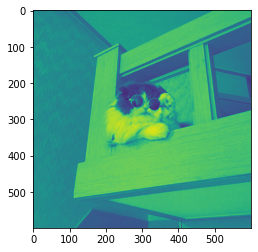

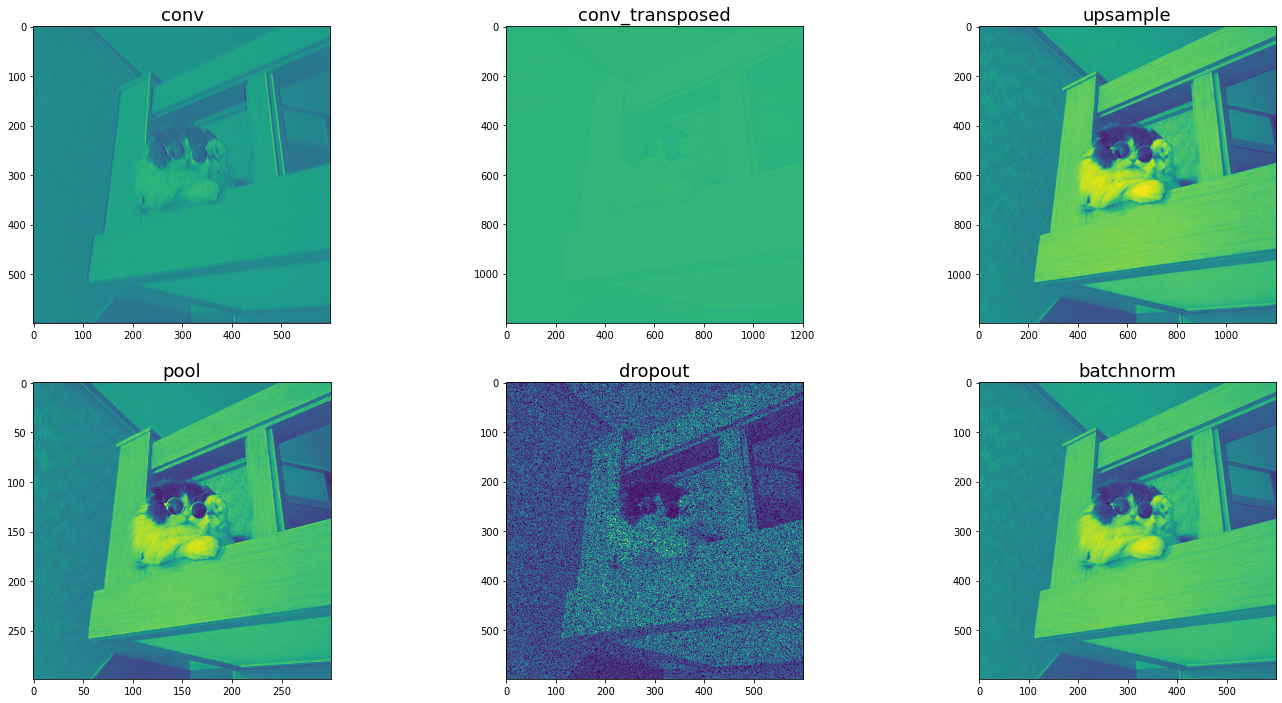

In [30]:
convolution = nn.Conv2d(1, 1, kernel_size=5, padding=2, stride=1)
transposed_convolution = nn.ConvTranspose2d(1, 1, kernel_size=4, stride=2)
upsampling = nn.UpsamplingBilinear2d(scale_factor=2)
pool = nn.MaxPool2d(kernel_size=2, stride=2)
dropout = nn.Dropout(0.5)
#dropout = nn.Dropout2d(0.5)
batchnorm = nn.BatchNorm2d(1) ##1 corresponds to the number of output channels in the convolutional layer

plt.imshow(img)

fig, axarr = plt.subplots(2, 3, figsize=(24, 12))
for ax, op, name in zip(axarr.flatten(), [convolution, transposed_convolution, upsampling, pool, dropout, batchnorm], ["conv", "conv_transposed", "upsample", "pool", "dropout", "batchnorm"]):
  filtered = op(x)
  im = ax.imshow(filtered[0, 0].detach().numpy())
  ax.set_title(name, fontsize=18)
  #fig.colorbar(im, ax=ax, fraction=0.03)
plt.show()

#下面为每个对图像的作用效果

### A clearer/simpler toy-example to understand [`nn.Dropout`](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html) layers:

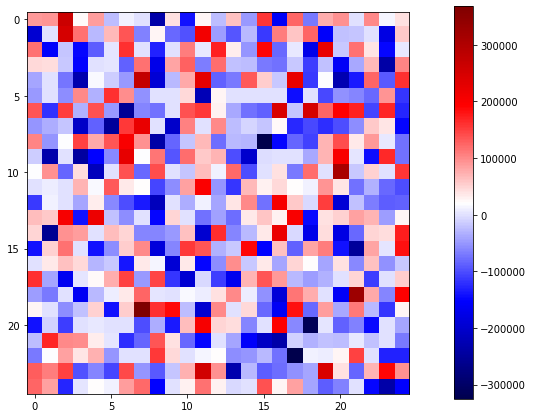

In [31]:
p = 0.1
m = nn.Dropout(p=p)
input = torch.randn(25, 25)*100000
output = m(input)

plt.figure(figsize = (8,8))
im = plt.imshow(output.detach().numpy(), cmap='seismic')#, vmin=-0.1, vmax=0.1)
plt.colorbar(im,fraction=0.044, pad=0.1)

what does the value p do?

### A clearer/simpler toy-example to understand [`nn.BatchNorm2d`](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html) layers:

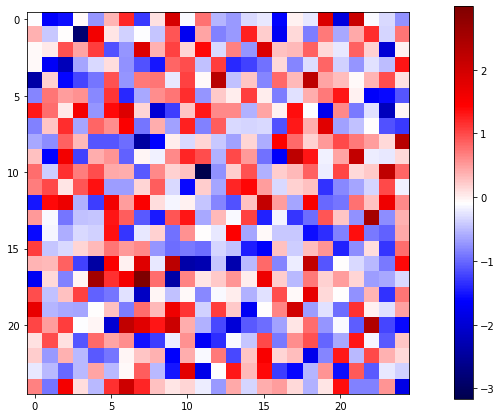

In [32]:
m = nn.BatchNorm2d(1)
input = torch.randn(1,1,25, 25)*100000
output = m(input)

plt.figure(figsize = (8,8))
im = plt.imshow(output[0,0].detach().numpy(), cmap='seismic')
plt.colorbar(im,fraction=0.044, pad=0.1)

<br>

### Before we start coding CNNs, let's make sure we know what we are doing:

[CNN Explainer](https://poloclub.github.io/cnn-explainer/)

<br>

[interactive cool MNIST classifeir](https://www.cs.ryerson.ca/~aharley/vis/conv/flat.html)

<br>

### Task 2: A simple Convolutional Network - LeNet-5 (almost)
![](https://www.researchgate.net/profile/Vladimir_Golovko3/publication/313808170/figure/fig3/AS:552880910618630@1508828489678/Architecture-of-LeNet-5.png)

We will now use the layer classes we just saw to implement a version of Yann LeCun's LeNet-5 (see figure above).


- Here the network is shown to have input's of size 32x32, so we will tell our first convolutional layer to add some padding to our 28x28 MNIST images. （这里显示网络的输入尺寸为32x32，所以我们将告诉我们的第一个卷积层为我们的28x28 MNIST图像添加一些填充。） 
- All convolutional layers with trainable parameters should have:（所有具有可训练参数的卷积层都应该有）
  - kernel-size=5
  - stride 1
  - padding 2.  
- All MaxPool layers use a kernel size 2 and a stride value of 2.（所有MaxPool层都使用2的内核大小和2的stride值）
- Use ReLUs for all activations.（所有激活函数都使用ReLUs）


In [33]:
class LeNet5(nn.Module):
  def __init__(self):
    super(LeNet5, self).__init__()
    self.c1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2) # define a 2D convolutional layer
    self.s2 = nn.MaxPool2d(kernel_size=2, stride=2)               # define a maxpool layer
    self.c3 = nn.Conv2d(6, 16, kernel_size=5, stride=1)           # new 2D convolutional layer
    self.s4 = nn.MaxPool2d(kernel_size=2, stride=2)               # another maxpool layer
    self.c5 = nn.Linear(16*5*5, 120)                              # first linear layer
    self.f6 = nn.Linear(120, 84)                                  # second linear layer
    self.output = nn.Linear(84, 10)                               # final output layer
    self.act = nn.ReLU()                                          # activation function
    
  def forward(self, x):
    x = self.act(self.c1(x))                                      # activate pass through the first layer
    x = self.act(self.s2(x))                                      # activate pass through the second layer
    x = self.act(self.c3(x))                                      # activate pass through the third layer
    x = self.act(self.s4(x))                                      # activate pass through the fourth layer
    x = x.view(-1, x.size(1)*x.size(2)*x.size(3))                 # flatten (return a "flattened" view of the 2d tensor as inputs for the fully connected layer)
    x = self.act(self.c5(x))                                      # activate pass through fifth layer
    x = self.act(self.f6(x))                                      # activate pass through last layer
    return self.output(x)                                         # return output
  
x = torch.randn((1, 1, 28, 28))
model = LeNet5()
y = model(x)
print(y)
print(model)

tensor([[ 0.0766, -0.0233,  0.0521,  0.0469, -0.1041,  0.0920, -0.0070,  0.0823,
         -0.0377, -0.1072]], grad_fn=<AddmmBackward>)
LeNet5(
  (c1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (s2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (c3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (s4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (c5): Linear(in_features=400, out_features=120, bias=True)
  (f6): Linear(in_features=120, out_features=84, bias=True)
  (output): Linear(in_features=84, out_features=10, bias=True)
  (act): ReLU()
)


**Bonus**: On the original [paper](http://vision.stanford.edu/cs598_spring07/papers/Lecun98.pdf) there were a few important differences from what we just implemented. Can you name any?

- No ReLUs but sigmoids and one weight and bias per pooling layer.
- Not all filters in S2-C3 act on all layers on S2

That's why we have an almost LeNet-5

### The MNIST Dataset - Hello World of Deep-Learning - Now with ConvNets!

In [35]:
mnist_train = MNIST("./", download=True, train=True)
mnist_test = MNIST("./", download=True, train=False)

### `code along` Instantiate and create a ```StratifiedShuffleSplit``` using sklearn.
1. Create a ```sklearn.model_selection.StratifiedShuffleSplit``` object with 1-split and a test-size of 10%.
2. Get the training and validation indices from the shuffel-split （从StratifiedShuffleSplit中获得训练集和验证集索引，训练集和验证集size比为9:1）

In [36]:
# split the data
shuffler = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42).split(mnist_train.train_data, mnist_train.train_labels) 
indices = [(train_idx, validation_idx) for train_idx, validation_idx in shuffler][0]

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:64: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:54: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


### `code along` Standardise and split the MNIST dataset
The original mnist data is given in gray-scale values between 0 and 255.
You will need to write a normalisation method that takes in a ```torch.Tensor``` and performs normalisation.
The mean of MNIST is 0.1307 and it's standard deviation is 0.3081 (after division by 255).

In [38]:
def apply_standardization(X): # define an standardisation function （定义标准化函数）
  X /= 255.
  X -= 0.1307
  X /= 0.3081
  return X

In [39]:
# standardise the data （标准化数据）
X_train, y_train = apply_standardization(mnist_train.train_data[indices[0]].float()), mnist_train.train_labels[indices[0]]
X_val, y_val = apply_standardization(mnist_train.train_data[indices[1]].float()), mnist_train.train_labels[indices[1]]
X_test, y_test =  apply_standardization(mnist_test.test_data.float()), mnist_test.test_labels

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:64: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:54: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:69: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:59: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


### `code along` Instantiate a ```torch.utils.data.TensorDataset``` for training, validation and test data

Remember that we use TensorDataset to be able to operate on the dataset without having to load it all in memory.（记住，我们使用TensorDataset来操作数据集，而不需要将它全部加载到内存中）

And remember that torch likes all categorical data to be in a ```.long()``` format.（同时记住，torch喜欢所有分类数据都是.long()格式）


In [40]:
# create the TensorDatasets containing mnist_train, mnist_validate, and mnist_test
mnist_train = TensorDataset(X_train, y_train.long())
mnist_validate = TensorDataset(X_val, y_val.long())
mnist_test = TensorDataset(X_test, y_test.long())

Let's visualise an example of the images and check whether the data is normalised properly (compute .mean() and .std() on the training set.)

tensor(0.0001) tensor(1.0003)


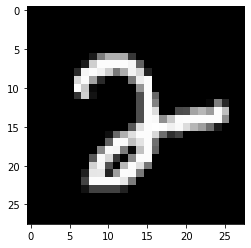

In [41]:
plt.imshow(X_train[0], cmap = 'gray')
print(X_train.mean(), X_train.std())

### Provided Train, Validation and Evaluate Functions

There is an error in these functions. Can you spot it?

In [44]:
def train(model, optimizer, criterion, data_loader):
    # 训练data_loader里所有数据一遍
    model.train()
    train_loss, train_accuracy = 0, 0
    for X, y in data_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        a2 = model(X.view(-1, 1, 28, 28))
        #a2 = model(X.view(-1, 28*28)) #What does this have to look like for our conv-net? Make the changes!
        loss = criterion(a2, y)
        loss.backward()
        train_loss += loss*X.size(0)
        y_pred = F.log_softmax(a2, dim=1).max(1)[1]
        train_accuracy += accuracy_score(y.cpu().numpy(), y_pred.detach().cpu().numpy())*X.size(0)
        optimizer.step()  
        
    return train_loss/len(data_loader.dataset), train_accuracy/len(data_loader.dataset)
  
def validate(model, criterion, data_loader):
    model.eval()
    validation_loss, validation_accuracy = 0., 0.
    for X, y in data_loader:
        with torch.no_grad():
            X, y = X.to(device), y.to(device)
            a2 = model(X.view(-1, 1, 28, 28))
            #a2 = model(X.view(-1, 28*28)) #What does this have to look like for our conv-net? Make the changes!
            loss = criterion(a2, y)
            validation_loss += loss*X.size(0)
            y_pred = F.log_softmax(a2, dim=1).max(1)[1]
            validation_accuracy += accuracy_score(y.cpu().numpy(), y_pred.cpu().numpy())*X.size(0)
            
    return validation_loss/len(data_loader.dataset), validation_accuracy/len(data_loader.dataset)
  
def evaluate(model, data_loader):
    model.eval()
    ys, y_preds = [], []
    for X, y in data_loader:
        with torch.no_grad():
            X, y = X.to(device), y.to(device)
            a2 = model(X.view(-1, 1, 28, 28))
            #a2 = model(X.view(-1, 28*28)) #What does this have to look like for our conv-net? Make the changes!
            y_pred = F.log_softmax(a2, dim=1).max(1)[1]
            ys.append(y.cpu().numpy())
            y_preds.append(y_pred.cpu().numpy())
            
    return np.concatenate(y_preds, 0),  np.concatenate(ys, 0)

 ### Set the hyperparameters of your model
- Seed: 42
- learning rate: 1e-2
- Optimizer: SGD
- momentum: 0.9
- Number of Epochs: 30
- Batchsize: 64
- Test Batch Size (no effect on training apart from time): 1000
- Shuffle the training set every epoch: Yes

In [45]:
seed = 42
lr = 1e-2
momentum = 0.5
batch_size = 64
test_batch_size = 1000
n_epochs = 30

### Instantiate our model, optimizer and loss function
Set the random number generator seed using ```set_seed``` to make everything reproducible.（使用set_seed设置随机数生成器种子，使所有内容都是可复制的）
As a criterion use a sensible loss for the multi-class classification problem.（在多类分类问题中，用一个可感知损失作为判别标准。）

### Perform the training of the network and validation
Here we provide you with a method to visualize both training and validation loss while training your networks.

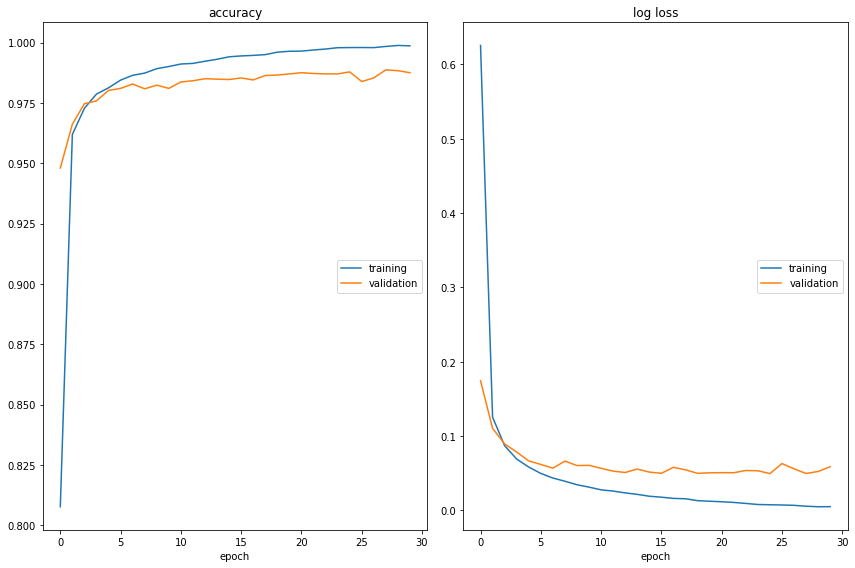

accuracy
	training         	 (min:    0.808, max:    0.999, cur:    0.999)
	validation       	 (min:    0.948, max:    0.989, cur:    0.988)
log loss
	training         	 (min:    0.005, max:    0.626, cur:    0.005)
	validation       	 (min:    0.049, max:    0.174, cur:    0.059)


In [46]:
def train_model(momentum):
  set_seed(seed)
  model = LeNet5().to(device)
  optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
  criterion = nn.CrossEntropyLoss()
  
  train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=0)
  validation_loader = DataLoader(mnist_validate, batch_size=test_batch_size, shuffle=False, num_workers=0)
  test_loader = DataLoader(mnist_test, batch_size=test_batch_size, shuffle=False, num_workers=0)
  
  liveloss = PlotLosses()
  for epoch in range(30):
      logs = {}
      #训练一代的训练集
      train_loss, train_accuracy = train(model, optimizer, criterion, train_loader)

      logs['' + 'log loss'] = train_loss.item()
      logs['' + 'accuracy'] = train_accuracy.item()

      #运行一代的验证集
      validation_loss, validation_accuracy = validate(model, criterion, validation_loader)
      logs['val_' + 'log loss'] = validation_loss.item()
      logs['val_' + 'accuracy'] = validation_accuracy.item()

      liveloss.update(logs)
      liveloss.draw()
      
  return model

model = train_model(0.5)

<br>

Results obtained with the feed-forward network from previous session:（使用前馈网络从前一次session中获得的结果）

<img src="https://raw.githubusercontent.com/acse-2020/ACSE-8/main/implementation/practical_4/Figs/MNIST_feedforward_cross-validation.png?token=ABNZJP5OYMSBT7U4IVOKBNTATTVH6" alt="results" width="600"/>

### `code along` Implement an evaluate method
This method performs the same as validate but doesn't report losses, but simply returns all predictions on a given dataset (training, validation, test-set)（此方法执行与验证相同的操作，但不报告损失，而是简单地返回给定数据集(训练、验证、测试集)的所有预测）

In [47]:
validation_loader = DataLoader(mnist_validate, batch_size=test_batch_size, shuffle=False, num_workers=0) # create a validation_loader 重新创建一个验证集数据加载器
y_pred, y_gt = evaluate(model, validation_loader) # generate predictions and ground truths by evaluating the model

### `code along` Plotting a confusion matrix

We can use a confusion matrix to diagnose problems in our models.（我们可以使用一个混淆矩阵来诊断我们模型的问题）
We may see for example that our model confuses 9's for 4's quite often.（我们可以看到我们的模型经常把9和4混淆）

In [48]:
cm = ConfusionMatrix(actual_vector=y_gt, predict_vector=y_pred) # Create CM From Data
print(cm) # print the confusion matrix

Predict   0         1         2         3         4         5         6         7         8         9         
Actual
0         590       0         0         0         0         0         0         0         2         0         

1         0         673       1         0         0         0         0         0         0         0         

2         0         1         590       1         1         0         1         1         1         0         

3         0         0         1         605       0         2         0         2         3         0         

4         0         0         0         0         581       0         0         1         1         1         

5         0         0         0         2         0         534       3         0         1         2         

6         2         0         0         0         2         0         588       0         0         0         

7         0         4         3         1         2         0         0         613       3       

/usr/local/lib/python3.7/dist-packages/pycm/pycm_obj.py:195: RuntimeWarning: The confusion matrix is a high dimension matrix and won't be demonstrated properly.
If confusion matrix has too many zeros (sparse matrix) you can set `sparse` flag to True in printing functions otherwise by using save_csv method to save the confusion matrix in csv format you'll have better demonstration.
  warn(CLASS_NUMBER_WARNING, RuntimeWarning)


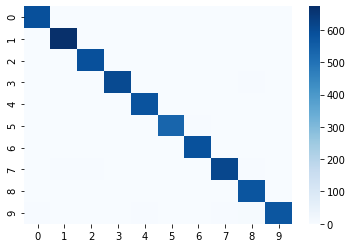

In [49]:
import seaborn as sns

def to_raw_matrix(cm):
    plt_cm = []
    for i in cm.classes :
        row=[]
        for j in cm.classes:
            row.append(cm.table[i][j])
        plt_cm.append(row)
    plt_cm = np.array(plt_cm)
    return plt_cm

rcm = to_raw_matrix(cm) #store the confusion matrix values

sns.heatmap(rcm, cmap="Blues") # use sensible limits to be able to see where the network struggles to identify digits

## `code along` Assume that you have estimated your hyperparameters.（假设您已经估计了超参数）

Now train your model on the full dataset and evaluate on the test set. How good is the accuracy?（现在，在完整的数据集上训练您的模型，并在测试集上进行评估。准确度有多高呢？）

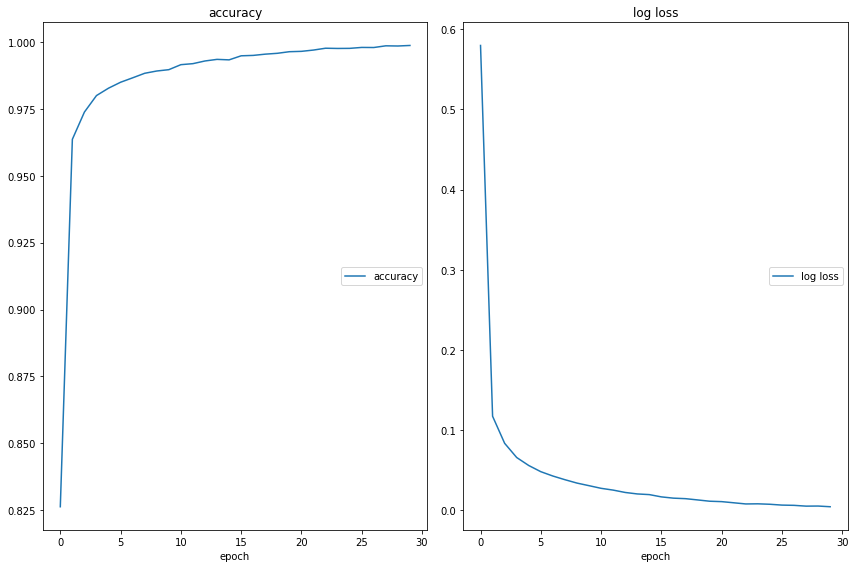

accuracy
	accuracy         	 (min:    0.826, max:    0.999, cur:    0.999)
log loss
	log loss         	 (min:    0.005, max:    0.580, cur:    0.005)
Avg. Test Loss: 0.037  Avg. Test Accuracy: 0.989



In [51]:
mnist_train = MNIST("./", download=True, train=True) # reload MNIST

# check the code from practical_3 if you get stuck.

X_train, y_train = apply_standardization(mnist_train.train_data.float()), mnist_train.train_labels
mnist_train = TensorDataset(X_train, y_train)
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=4)

set_seed(seed)
model = LeNet5().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
criterion = nn.CrossEntropyLoss()

liveloss = PlotLosses()
for epoch in range(n_epochs):
    logs = {}
    train_loss, train_accuracy = train(model, optimizer, criterion, train_loader)

    logs['' + 'log loss'] = train_loss.item()
    logs['' + 'accuracy'] = train_accuracy.item()
    liveloss.update(logs)
    liveloss.draw()
    logs['val_' + 'log loss'] = 0.
    logs['val_' + 'accuracy'] = 0.
    
    
# validation_loader = DataLoader(mnist_validate, batch_size=test_batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(mnist_test, batch_size=test_batch_size, shuffle=False, num_workers=0)

test_loss, test_accuracy = validate(model, criterion, test_loader)    
print("Avg. Test Loss: %1.3f" % test_loss.item(), " Avg. Test Accuracy: %1.3f" % test_accuracy.item())
print("")

model_save_name = 'LeNet5_mnist_classifier.pt'
path = F"/content/gdrive/My Drive/models/{model_save_name}" 
torch.save(model.state_dict(), path)

<br>

Results obtained with the feed-forward network from previous session:

<img src="https://raw.githubusercontent.com/acse-2020/ACSE-8/main/implementation/practical_4/Figs/MNIST_feedforward_final_training.png?token=ABNZJPY2YVTCBMJ7LSUOVJTATTUOG" alt="results" width="600"/>


# Summary of today's session:

- Convolutions as building blocks of CNNs.
- Overview of a few PyTorch layers used in CNNs.
- LeNet-5 architecture.
- Training a network similar to LeNet-5 of MNIST.
- Demonstration that CNNs are superior to feed-forward networks because they are aware of the spatial context of the input images.（证明cnn优于前馈网络，因为它们知道输入图像的空间信息）


---

## Custom Datasets and Transforms

Pytorch allows us to simply extend the available Datasets to more custom functionality.
Here we provide an example of such a custom dataset class.
You can see that there are 3 functions we need to implement:（Pytorch允许我们简单地将可用的数据集扩展更多的自定义功能。这里我们提供了这样一个自定义数据集类的示例。您可以看到我们需要实现3个函数）
- __init__(*args, **kwargs): this will handle everything prior to actually using the dataset（这将在实际使用数据集之前处理所有事情）
- __len__(self): returns the length of the dataset i.e. the number of data items（返回数据项的个数）
- __getitem__(self, idx): this method takes an index of a specific data item and returns that item.（此方法接受特定数据项的索引并返回该项。）
  - You can do whatever you want in these functions: apply transforms, normalize data, perform another computation etc.（你可以在这些函数中做任何你想做的事情:应用转换，规范化数据，执行另一个计算等等）
  - Here we also have the functionality to apply a set of [```torchvision.transforms```](https://pytorch.org/tutorials/beginner/data_loading_tutorial.

In [54]:
from torch.utils.data import Dataset 

class CustomImageTensorDataset(Dataset):
    def __init__(self, data, targets, transform=None):
        """
        Args:
            data (Tensor): A tensor containing the data e.g. images
            targets (Tensor): A tensor containing all the labels
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data = data
        self.targets = targets
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample, label = self.data[idx], self.targets[idx]
        sample = sample.view(1, 28, 28).float()/255.
        if self.transform:
            sample = self.transform(sample)

        return sample, label

### Transforms

Transforms can be used to perform manipulation of individual data prior to passing the data to our models.（转换可用于在将数据传递给模型之前对单个数据进行操作）
This is useful for:
 - Data-augmentation i.e. creating slightly modified instance of the data we have while preserving their labels.
 - Data Preprocessing: Such as Normalization, Histogram Equalization 
 - Transforming Targets: You may have complex labels that should change together with changes in the preprocessing of the images
 
 Pytorch and especially torchvision provides a [number of transforms](https://pytorch.org/docs/stable/torchvision/index.html) for you to use!
 A nice tutorial on custom dataloaders and transforms can be found [here](https://github.com/utkuozbulak/pytorch-custom-dataset-examples).
 
 The (probably) most state-of-the-art library for image augmentation is [albumentations](https://github.com/albu/albumentations) which has been successfully applied in winning kaggle competitions.
 

In [55]:
from torchvision.transforms import Compose, ToTensor, Normalize, RandomRotation, ToPILImage


#Often we will want to apply more transformations at training time than test time, therefore here we have two different ones
train_transform = Compose([
    ToPILImage(),
    RandomRotation(10),
    ToTensor(),
    Normalize(mean=[0.1307], std=[0.3081]), 

]) ##Compose different transforms together. PIL is Python Imaging Library useful for opening, manipulating, and saving many different image file formats.

#In Validation and Test Mode we only want to normalize our images, because they are already tensors
validation_test_transform = Compose([
    Normalize(mean=[0.1307], std=[0.3081])
])


<img src="https://raw.githubusercontent.com/acse-2020/ACSE-8/main/implementation/practical_4/Figs/data_augmentation.png?token=ABNZJP4FGWYIGD6DLD3KGVDATZENK" alt="network" width="600"/>


### `code along` Training with data augmentation

- Instantiate a ```CustomImageTensorDataset``` with data from the MNIST dataset
- Provide the training and validation and testing datasets with the right transforms
- Train LeNet-5 with data-augmentation on a validation set, then train on the full training set and report accuracies. Did you improve the model?






#### Create the ```CustomImageTensorDataset```:

In [57]:
mnist_train = MNIST("./", download=True, train=True)   # download mnist
X_train, y_train = mnist_train.data[indices[0]], mnist_train.targets[indices[0]]    # split in train and validation
X_val, y_val = mnist_train.data[indices[1]], mnist_train.targets[indices[1]]

# 使用之前定义的转换操作作为参数来创建自定义数据集，对数据进行了转换
custom_mnist_train = CustomImageTensorDataset(X_train, y_train, transform=train_transform)     # create train custom dataset
mnist_validation = CustomImageTensorDataset(X_val, y_val, transform=validation_test_transform) # create validation custom dataset
mnist_test = CustomImageTensorDataset(X_test, y_test, transform=validation_test_transform)     # create test custom dataset

print(custom_mnist_train.__len__())
print(mnist_validation.__len__())
print(mnist_test.__len__())

54000
6000
10000


### Training LeNet5 with data augmentation

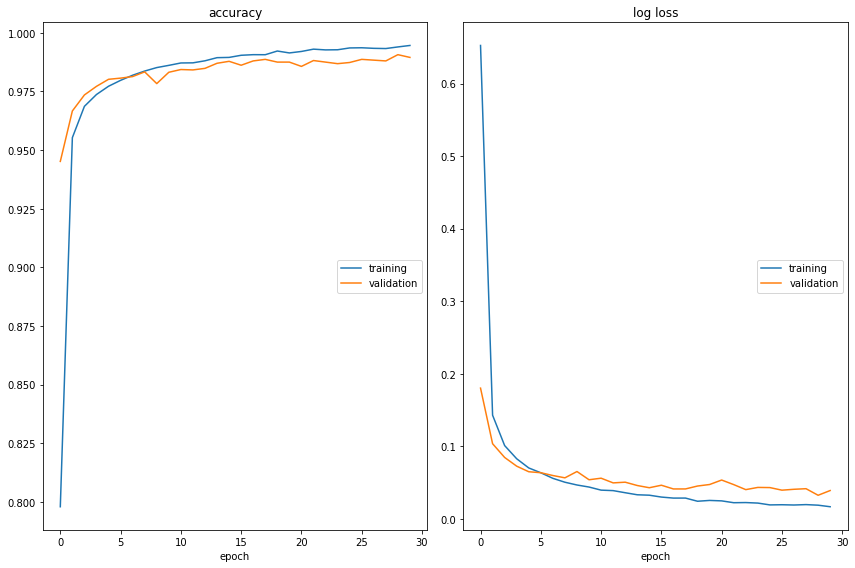

accuracy
	training         	 (min:    0.798, max:    0.995, cur:    0.995)
	validation       	 (min:    0.945, max:    0.991, cur:    0.990)
log loss
	training         	 (min:    0.017, max:    0.652, cur:    0.017)
	validation       	 (min:    0.033, max:    0.180, cur:    0.039)


In [58]:
def train_model_augmented(train_dataset, validation_dataset, momentum=0.5):
  set_seed(seed)
  model = LeNet5().to(device)
  optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
  criterion = nn.CrossEntropyLoss()
  
  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
  validation_loader = DataLoader(validation_dataset, batch_size=test_batch_size, shuffle=False, num_workers=0)

  liveloss = PlotLosses()
  for epoch in range(30):
      logs = {}
      train_loss, train_accuracy = train(model, optimizer, criterion, train_loader)

      logs['' + 'log loss'] = train_loss.item()
      logs['' + 'accuracy'] = train_accuracy.item()

      validation_loss, validation_accuracy = validate(model, criterion, validation_loader)
      logs['val_' + 'log loss'] = validation_loss.item()
      logs['val_' + 'accuracy'] = validation_accuracy.item()

      liveloss.update(logs)
      liveloss.draw()
      
  return model

model = train_model_augmented(custom_mnist_train, mnist_validation)

### Training on the full dataset

We can apply transforms directly when we get MNIST from [`torchvision.datasets.MNIST`](https://pytorch.org/vision/stable/datasets.html#mnist)


In [1]:
# 我们从torchvision.datasets.MNIST中获得MNIST时，我们可以直接应用转换
mnist_train = MNIST("./", download=True, train=True, transform=Compose([
    RandomRotation(10),
    ToTensor(),
    Normalize(mean=[0.1307], std=[0.3081]), 

]))
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(mnist_test, batch_size=test_batch_size, shuffle=False, num_workers=0)    

set_seed(seed)
model = LeNet5().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
criterion = nn.CrossEntropyLoss()

liveloss = PlotLosses()
for epoch in range(n_epochs):
    logs = {}
    train_loss, train_accuracy = train(model, optimizer, criterion, train_loader)

    logs['' + 'log loss'] = train_loss.item()
    logs['' + 'accuracy'] = train_accuracy.item()
    liveloss.update(logs)
    liveloss.draw()
    logs['val_' + 'log loss'] = 0.
    logs['val_' + 'accuracy'] = 0.

test_loss, test_accuracy = validate(model, criterion, test_loader)    
print("Avg. Test Loss: %1.3f" % test_loss.item(), " Avg. Test Accuracy: %1.3f" % test_accuracy.item())
print("")

model_save_name = 'LeNet5_mnist_classifier_with_augmentation.pt'
path = F"/content/gdrive/My Drive/models/{model_save_name}" 
torch.save(model.state_dict(), path)

NameError: ignored

#### And voila! we have improved a bit more the accuracy of our test set!